# SISO LINEAR MODULAR (SLM) REACTION NETWORKS

This notebook contains numerical studies to check the derivation of transfer functions for compositions
of SLM reaction networks.

In [1]:
import sys
sys.path.insert(0, "/Users/jlheller/home/Technical/repos/controlSBML/src")

In [2]:
import lrn_builder.slm_network
from lrn_builder.named_transfer_function import NamedTransferFunction

In [3]:
import numpy as np
import pandas as pd
import tellurium as te
import matplotlib.pyplot as plt
import sympy as sp
import control
from lrn_builder.slm_network import SLMNetwork

# Helpers 

In [4]:
s = control.TransferFunction.s

In [5]:
SLM_A = SLMNetwork.makeTwoSpeciesNetwork(1, 1)
SLM_A.template


        model <<model_name>>()
        SI -> SO; kIO*SI
        SO -> ; kO*SO
        kIO = 1.000000
        kO = 1.000000
        SI = 0
        SO = 0
        end
        

In [6]:
SLM_B = SLMNetwork.makeTwoSpeciesNetwork(2, 2)
SLM_B.template


        model <<model_name>>()
        SI -> SO; kIO*SI
        SO -> ; kO*SO
        kIO = 2.000000
        kO = 2.000000
        SI = 0
        SO = 0
        end
        

In [7]:
TEST_MODEL = """
model *main()
$SI -> SO; TEST_KIO*SI
SO ->; TEST_KO*SO

SI = 0
TEST_KIO = 2
TEST_KO = 1
end
"""

In [8]:
TEST_KIO = 2
TEST_KO = 1
TEST_TF = control.TransferFunction([TEST_KIO], [1, TEST_KO])

In [9]:
def plotStep(model=None, tf=None, title="", figsize=(8, 8), is_plot=True, **kwargs):
    """
    Assumes that input is SI and output is SO

    Args:

    Returns:
        np.array (data from simulation)
        np.array (predictions)
    """
    if "SI" in kwargs.keys():
        SI = kwargs["SI"]
    else:
        raise ValueError("Must specify input SI")
    #
    _, ax = plt.subplots(1, figsize=figsize)
    if model is not None:
        rr = te.loada(model)
        for key, value in kwargs.items():
            rr[key] = value
        selections = ["time", "SO"]
        data = rr.simulate(selections=selections)
    else:
        data = None
    if data is None:
            times = np.linspace(0, 5, 50)
    else:
        times = data["time"]
    if tf is not None:
        times, predictions = control.step_response(tf, T=times)
        predictions = SI*predictions
    else:
        predictions = None
    if (tf is not None) and (model is not None):
        ax.scatter(data[:, 1], predictions, color="red", marker="*")
        ax.set_xlabel("simulated")
        ax.set_ylabel("predicted")
        max_simulated = np.max(data[:, 1])
        max_predictions = np.max(predictions)
        max_value = max(max_simulated, max_predictions)
        ax.plot([0, max_value], [0, max_value], linestyle="--")
    else:
        if data is not None:
            ax.scatter(times, data[:, 1], marker="o")
            ax.set_xlabel("time")
            ax.set_ylabel("simulations")
        elif predictions is not None:
            ax.scatter(times, predictions, marker="o")
            ax.set_xlabel("time")
            ax.set_ylabel("predictions")
    ax.set_title(title)
    if not is_plot:
        plt.close()
    return data, predictions

# Tests
is_plot = False
data, _ = plotStep(model=TEST_MODEL, SI=5, TEST_KIO=TEST_KIO, TEST_KO=TEST_KO, title="test", figsize=(3,3), is_plot=is_plot)
assert(data[-1, 1] > 0)
_ = plotStep(SI=5, tf=TEST_TF, TEST_K12=TEST_KIO, TEST_K2=TEST_KO, title="test", figsize=(3,3), is_plot=is_plot)
_ = plotStep(model=TEST_MODEL, SI=5, tf=TEST_TF, TEST_KIO=TEST_KIO, TEST_KO=TEST_KO, title="test", figsize=(3,3), is_plot=is_plot)
print("OK!")

OK!


# SLM Networks

## Sequential

## Linear Repressilator

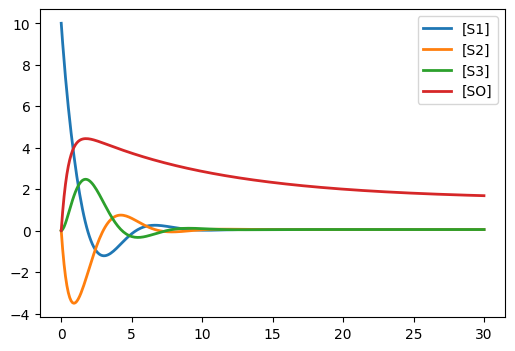

In [63]:
model_lr = """
$SI -> S1; k1s*SI
$SI -> S2; k2s*SI
$SI -> S3; k3s*SI
S1 -> ; k1d*S3
S2 -> ; k2d*S1
S3 -> ; k3d*S2
S1 -> SO; k1O*S1
S2 -> SO; k2O*S2
S3 -> SO; k3O*S3
SO -> ; k5*SO
k1s = .1
k2s = .1
k2s = .1
k3s = .1
k1d = 1
k2d = 1
k3d = 1
k1O = 1
k2O = 1
k3O = 1
k5 = 0.1
SI = 1
S1 = 10
S2 = 0
S3 = 0
SO = 0
"""
rr = te.loada(model_lr)
rr.simulate(0, 30, 300)
rr.plot()

**Issues**
1. Negative concentrations

# Operations on Networks

## Scale

## Concatenate

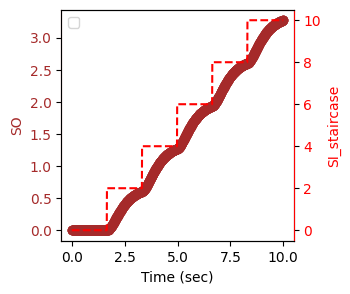

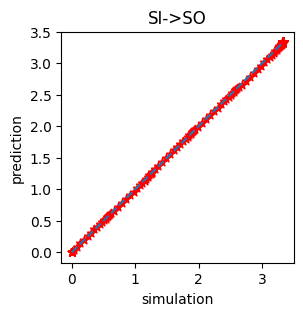

model *main_model()

            A: main_model_1();
            B: main_model_2();
            A.SO is B.SI;
            SI is A.SI
            SO is B.SO
            
end

In [10]:
slm = SLM_A.copy()
slm_concatenate = slm.concatenate(SLM_B)
_ = slm_concatenate.isValid(is_plot=True, figsize=(3,3))
slm_concatenate.template

For all models, S1 is the input and S2 is the output.

## Branchjoin Operation

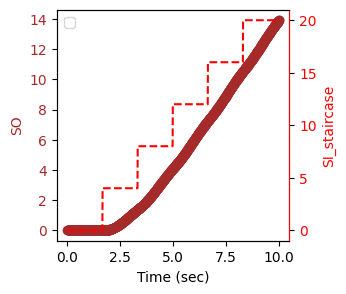

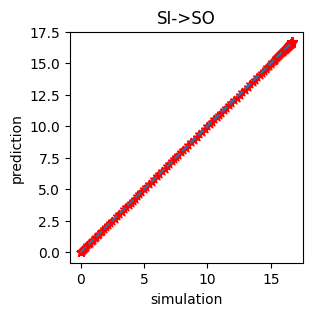

model *main_model()

            A: main_model_1();
            B: main_model_2();
            species SI, SO
            SAI is A.SI
            SBI is B.SI
            SAO is A.SO
            SBO is B.SO
            SI -> SAI; k1a*SI
            SI -> SBI; k1b*SI
            SAO -> SO; k2a*SAO
            SBO -> SO; k2b*SBO
            SO -> ; k3*SO
            k1a = 1.000000
            k1b = 1.000000
            k2a = 1.000000
            k2b = 1.000000
            k3 = 1.000000
            
end

In [11]:
slm_a = SLM_A.copy()
slm_branchjoin = slm_a.branchjoin(SLM_B)
_ = slm_branchjoin.isValid(is_plot=True, figsize=(3,3))
slm_branchjoin.template

## Positive Feedback Operation

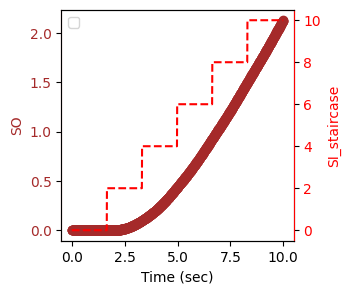

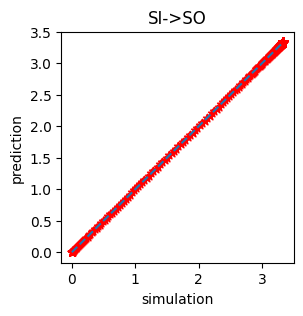

model *main_model()

            A: main_model_1();
            species SI, SO
            SAI is A.SI
            SAO is A.SO
            SI -> XI; k1*SI
            XI -> SAI; k2*XI
            SAO -> SO; k3*SAO
            SO -> ; k4*SO
            SO -> XI; k5*SO
            k1 = 1.000000
            k2 = 1.000000
            k3 = 1.000000
            k4 = 1.000000
            k5 = 1.000000
            
end

In [12]:
slm_a = SLM_A.copy()
slm_pfeedback = slm_a.pfeedback()
_ = slm_pfeedback.isValid(is_plot=True, figsize=(3,3))
slm_pfeedback.template

## Negative feedback

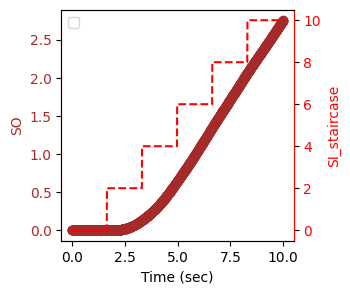

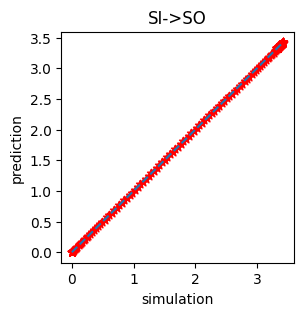

model *main_model()

            A: main_model_1();
            species SI, SO
            SAI is A.SI
            SAO is A.SO
            SI -> XI; k1*SI
            XI -> SAI; k2*XI
            SAO -> SO; k3*SAO
            SO -> ; k4*SO
            XI -> ; k5*SO
            k1 = 1.000000
            k2 = 1.000000
            k3 = 1.000000
            k4 = 1.000000
            k5 = 1.000000
            
end

In [13]:
slm_a = SLM_A.copy()
slm_nfeedback = slm_a.nfeedback()
_ = slm_nfeedback.isValid(is_plot=True, figsize=(3,3))
slm_nfeedback.template

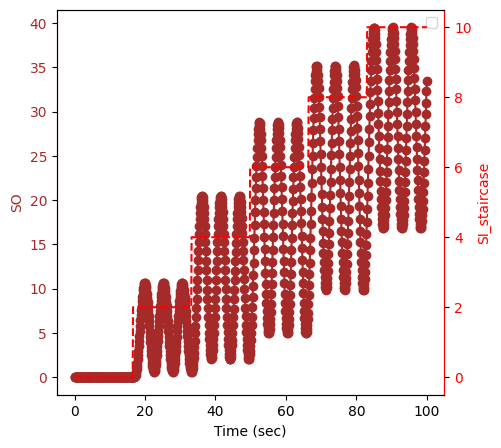

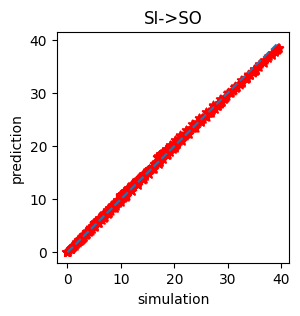

0.15726290516206481

In [21]:
slm_nfeedback = slm_a.nfeedback(k1=30, k5=8.65)
#slm_nfeedback = slm_a.nfeedback()
_, builder = slm_nfeedback.plotStaircaseResponse(times=np.linspace(0, 100, 1000))
df, score = slm_nfeedback.named_transfer_function.evaluate(str(builder), is_plot=True, figsize=(3,3))
score

In [18]:
print(slm_nfeedback.getAntimony())


        model main_model_1()
        SI -> SO; kIO*SI
        SO -> ; kO*SO
        kIO = 1.000000
        kO = 1.000000
        SI = 0
        SO = 0
        end
        
model *main_model()

            A: main_model_1();
            species SI, SO
            SAI is A.SI
            SAO is A.SO
            SI -> XI; k1*SI
            XI -> SAI; k2*XI
            SAO -> SO; k3*SAO
            SO -> ; k4*SO
            XI -> ; k5*SO
            k1 = 1.000000
            k2 = 1.000000
            k3 = 1.000000
            k4 = 1.000000
            k5 = 1.000000
            
end


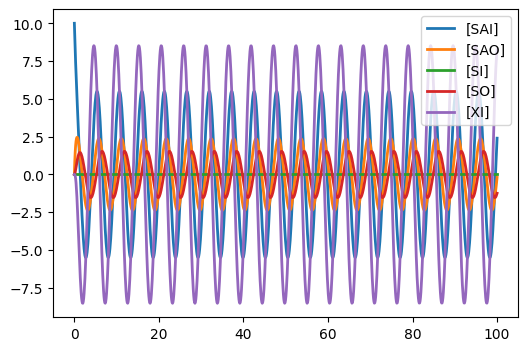

In [27]:
model = """
 model main_model_1()
        SI -> SO; kIO*SI
        SO -> ; kO*SO
        kIO = 1.000000
        kO = 1.000000
        SI = 10
        SO = 0
        end
        
model *main_model()

            A: main_model_1();
            species SI, SO
            SAI is A.SI
            SAO is A.SO
            SI -> XI; k1*SI
            XI -> SAI; k2*XI
            SAO -> SO; k3*SAO
            SO -> ; k4*SO
            XI -> ; k5*SO
            k1 = 30
            k2 = 1.000000
            k3 = 1.000000
            k4 = 1.000000
            k5 =8.64
            
end
"""
rr = te.loada(model)
rr.simulate(0, 100, 1000)
rr.plot()